In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import zscore, boxcox
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import IntProgress
from tqdm import tnrange, tqdm_notebook

from sklearn import utils
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# Classifiers
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

%matplotlib notebook

c:\python37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


## Define Parameters & Function 

In [2]:
classifiers = {}

classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"MLP": MLPClassifier()})
# Create dict of decision function labels
# DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
# FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [3]:
# Initiate parameter grid
parameters = {}

# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["sqrt", "log2"],
                                    "classifier__max_depth" : [3, 7],
                                    "classifier__min_samples_split": [0.01, 0.10],
                                    "classifier__min_samples_leaf": [0.01, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["sqrt", "log2"],
                                            "classifier__max_depth" : [3, 5, 7],
                                            "classifier__min_samples_split": [0.01, 0.10],
                                            "classifier__min_samples_leaf": [0.01, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})

# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["sqrt", "log2"],
                            "classifier__max_depth" : [1,3,5,7,10],
                            "classifier__min_samples_split": [0.01, 0.10],
                            "classifier__min_samples_leaf": [0.01, 0.10],
                             }})

In [4]:
def getBestHyperParam(x, y, classifier, scoring='roc_auc'):
    
    selected_classifier = classifier
    classifier = classifiers[selected_classifier]

    # Scale features via Z-score normalization
    #scaler = MinMaxScaler()

    # Define steps in pipeline
    steps = [("classifier", classifier)]
    # steps = [("scaler", scaler), ("classifier", classifier)]

    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)

    # Define parameter grid
    param_grid = parameters[selected_classifier]

    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs=-1, verbose=1, scoring=scoring)

    # Fit gscv
    print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
    y_train_bn = label_binarize(y, classes=[1, 2, 3])
    #gscv.fit(X_train_scaled, y_train) 
    gscv.fit(x, y_train_bn) 

    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_

    # Update classifier parameters
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)

    return classifier

def getBestFeat(x, y, params, num_feats=None):
    # Choose Best Parameters
    num_feats = num_feats
    selector = SelectFromModel(params, max_features=num_feats)
    selector.fit(x, y)

    support = selector.get_support()
    feature =x.loc[:, support].columns.tolist()
    # print(feature, 'selected features')
    return feature

def getFeatImpt(x_train, x_test, y_train, params, feature, saveTag):
    # Feature Infortance
    X_train_fi = x_train[feature]
    X_test_fi = x_test[feature]

    # Train classifier
    params.fit(X_train_fi, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame(feature, columns = ["Feature Label"])
    feature_importance["Feature Importance"] = params.feature_importances_

    # Sort by feature importance
    feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

    # Set graph style
    sns.set(font_scale=1.0)
    sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
                   "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
                   'ytick.color': '0.4'})

    # Set figure size and create barplot
    f, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x="Feature Importance", y="Feature Label",
                palette=reversed(sns.color_palette('YlOrRd', 15)), data=feature_importance)

    # Generate a bolded horizontal line at y = 0
    ax.axvline(x=0, color='black', linewidth=4, alpha=0.7)

    # Turn frame off
    ax.set_frame_on(False)

    # Rearrange the layout
    plt.tight_layout()

    # Save Figure
    plt.savefig("./img/feature_importance_" + saveTag + ".png", dpi=1080)

## Analysis Method 1

### Model 1 - (1) Data preprocessing

In [5]:
# Load dataset
df = pd.read_csv("./data/wafer_Inspection.csv")
df.head()

,NCELL,P01_TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,P01_WINS_CLASS,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_DEFECTAREAPERCENT,P01_PLI_DEFECTAVERAGE,P01_PLI_GRAINDEFECTAREAPERCENT,P01_PLI_EFFICIENCY,P01_PLI_RELATIVEEFFICIENCY,P01_PLI_SIGMALIFETIME
0,0.220886,0.79,1300712,Good,8.371416,167.011993,8.32,1.29531,1.064450,0,0,0,0,0,0.09384
1,0.222100,0.73,1300728,Good,3.696186,171.750000,10.27,1.36469,7.455840,0,0,0,0,0,0.22093
2,0.218838,0.75,1300728,Good,4.932078,173.442993,16.16,1.38156,8.013530,0,0,0,0,0,0.22542
3,0.223447,0.99,1300728,Good,2.840997,171.082001,13.53,1.25106,21.949989,0,0,0,0,0,0.21855
4,0.214146,0.86,1300728,Good,7.873027,168.774994,15.37,1.26393,15.115940,0,0,0,0,0,0.16036


In [6]:
# Check missing values of the dataset
idx =  df.isna().sum().index.values
idx = pd.Series(idx.T)
val = df.isna().sum().values
val = pd.Series(val.T)

null_cnt = pd.concat([idx, val] , axis=1).rename(columns={0:'feature', 1:'Missing Value Count'})
null_cnt

,feature,Missing Value Count
0,NCELL,0
1,P01_TTR_RESISTIVITY,0
2,P01_WINS_PRODUCTORDER,0
3,P01_WINS_CLASS,0
4,P01_TTR_WARP,0
5,P01_TTR_AVRTHICKNESS,0
6,P01_TTR_TTV,0
7,P01_PLI_AVERAGELIFETIME,0
8,P01_PLI_DARKAREAPERCENT,0
9,P01_PLI_DEFECTAREAPERCENT,0


In [7]:
# Add additional features of output
df['NCELL2'] = df['NCELL']* 100    # 
df.loc[df['NCELL'] < 0.2, 'NCELL_Grade'] = 1
df.loc[(df['NCELL'] >= 0.2) & (df['NCELL'] < 0.22), 'NCELL_Grade'] = 2
df.loc[df['NCELL'] >= 0.22, 'NCELL_Grade'] = 3
df['NCELL_Grade'] = df['NCELL_Grade'].astype(int)
df.head()

,NCELL,P01_TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,P01_WINS_CLASS,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_DEFECTAREAPERCENT,P01_PLI_DEFECTAVERAGE,P01_PLI_GRAINDEFECTAREAPERCENT,P01_PLI_EFFICIENCY,P01_PLI_RELATIVEEFFICIENCY,P01_PLI_SIGMALIFETIME,NCELL2,NCELL_Grade
0,0.220886,0.79,1300712,Good,8.371416,167.011993,8.32,1.29531,1.064450,0,0,0,0,0,0.09384,22.0886,3
1,0.222100,0.73,1300728,Good,3.696186,171.750000,10.27,1.36469,7.455840,0,0,0,0,0,0.22093,22.2100,3
2,0.218838,0.75,1300728,Good,4.932078,173.442993,16.16,1.38156,8.013530,0,0,0,0,0,0.22542,21.8838,2
3,0.223447,0.99,1300728,Good,2.840997,171.082001,13.53,1.25106,21.949989,0,0,0,0,0,0.21855,22.3447,3
4,0.214146,0.86,1300728,Good,7.873027,168.774994,15.37,1.26393,15.115940,0,0,0,0,0,0.16036,21.4146,2


<IPython.core.display.Javascript object>


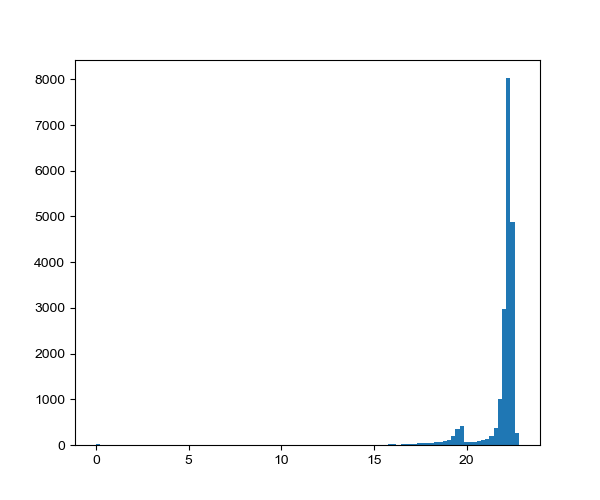

In [8]:
# Draw histogram of NCELL2 variable
plt.figure(figsize=(6,5))
plt.hist(df['NCELL2'], bins=100)
plt.show()

<IPython.core.display.Javascript object>


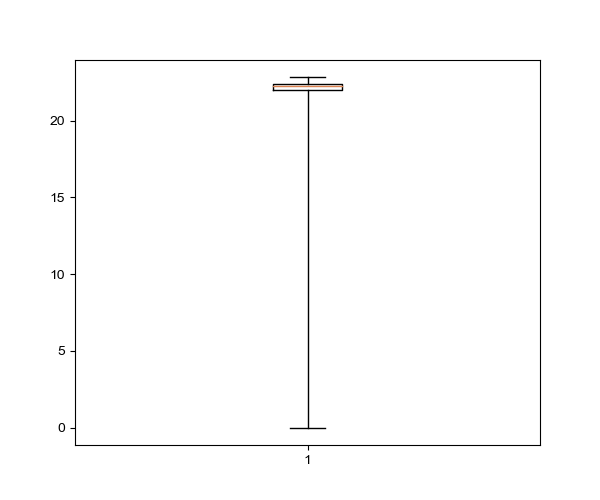

In [9]:
# Draw box plot of NCELL2 varibale
plt.figure(figsize=(6,5))
plt.boxplot(df['NCELL2'], whis='range')
plt.show()

In [17]:
# Check the minimum and maximum values of the NCELL2 variable
df['NCELL2'].min(), df['NCELL2'].max()

(0.0, 22.8171)

In [10]:
# View counts of the categorical variables
df.loc[:,['NCELL', 'P01_WINS_PRODUCTORDER','P01_WINS_CLASS']].groupby(['P01_WINS_PRODUCTORDER', 'P01_WINS_CLASS']).count()

NCELL
P01_WINS_PRODUCTORDER P01_WINS_CLASS       
1300673               Good                2
1300708               Good              757
1300712               Good            12056
1300728               Good             7179
                      Microcrack          2
                      OQ                  1
                      ThickTTV            4

In [11]:
# Drop the extreamely unbalanced feature
df.drop(columns=['P01_WINS_CLASS'], axis=1, inplace=True)
df.head()

,NCELL,P01_TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_DEFECTAREAPERCENT,P01_PLI_DEFECTAVERAGE,P01_PLI_GRAINDEFECTAREAPERCENT,P01_PLI_EFFICIENCY,P01_PLI_RELATIVEEFFICIENCY,P01_PLI_SIGMALIFETIME,NCELL2,NCELL_Grade
0,0.220886,0.79,1300712,8.371416,167.011993,8.32,1.29531,1.064450,0,0,0,0,0,0.09384,22.0886,3
1,0.222100,0.73,1300728,3.696186,171.750000,10.27,1.36469,7.455840,0,0,0,0,0,0.22093,22.2100,3
2,0.218838,0.75,1300728,4.932078,173.442993,16.16,1.38156,8.013530,0,0,0,0,0,0.22542,21.8838,2
3,0.223447,0.99,1300728,2.840997,171.082001,13.53,1.25106,21.949989,0,0,0,0,0,0.21855,22.3447,3
4,0.214146,0.86,1300728,7.873027,168.774994,15.37,1.26393,15.115940,0,0,0,0,0,0.16036,21.4146,2


In [13]:
# View counts of the categorical variables
prod_order = df.loc[:,['NCELL','P01_WINS_PRODUCTORDER']].groupby('P01_WINS_PRODUCTORDER').count()
prod_order

,NCELL
P01_WINS_PRODUCTORDER,
1300673,2
1300708,757
1300712,12056
1300728,7186


In [21]:
# Drop the extreamely unbalanced feature
df.drop(columns=['P01_WINS_PRODUCTORDER'], axis=1, inplace=True)
df.head()

KeyError: "['P01_WINS_PRODUCTORDER'] not found in axis"

<IPython.core.display.Javascript object>


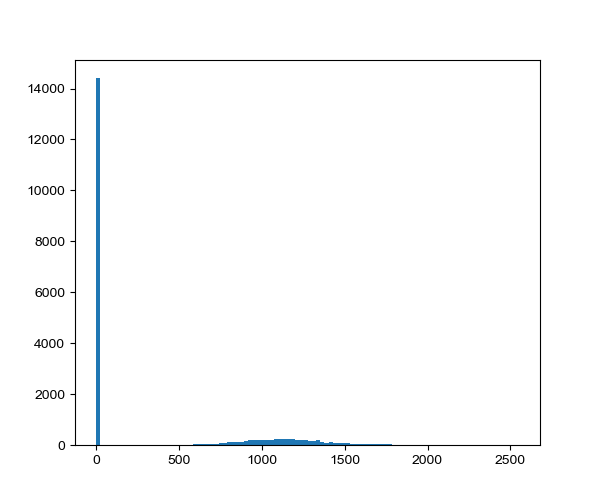

In [17]:
# 
plt.figure(figsize=(6,5))
plt.hist(df['P01_PLI_AVERAGELIFETIME'], bins=100)
plt.show()

In [22]:
# Drop the extreamely unbalanced feature
df.drop(columns=['P01_PLI_AVERAGELIFETIME'], axis=1, inplace=True)
df.head()

,NCELL,P01_TTR_RESISTIVITY,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_DARKAREAPERCENT,P01_PLI_DEFECTAREAPERCENT,P01_PLI_DEFECTAVERAGE,P01_PLI_GRAINDEFECTAREAPERCENT,P01_PLI_EFFICIENCY,P01_PLI_RELATIVEEFFICIENCY,P01_PLI_SIGMALIFETIME,NCELL2,NCELL_Grade
0,0.220886,0.79,8.371416,167.011993,8.32,1.064450,0,0,0,0,0,0.09384,22.0886,3
1,0.222100,0.73,3.696186,171.750000,10.27,7.455840,0,0,0,0,0,0.22093,22.2100,3
2,0.218838,0.75,4.932078,173.442993,16.16,8.013530,0,0,0,0,0,0.22542,21.8838,2
3,0.223447,0.99,2.840997,171.082001,13.53,21.949989,0,0,0,0,0,0.21855,22.3447,3
4,0.214146,0.86,7.873027,168.774994,15.37,15.115940,0,0,0,0,0,0.16036,21.4146,2


In [22]:
# These columns have only 0 value 
print(df['P01_PLI_DEFECTAREAPERCENT'].unique(),
      df['P01_PLI_DEFECTAVERAGE'].unique(),
      df['P01_PLI_GRAINDEFECTAREAPERCENT'].unique(),
      df['P01_PLI_EFFICIENCY'].unique(),
      df['P01_PLI_RELATIVEEFFICIENCY'].unique())

[0] [0] [0] [0] [0]


In [31]:
# Drop columns that only have 0 value
df.drop(columns=['P01_PLI_DEFECTAREAPERCENT','P01_PLI_DEFECTAVERAGE','P01_PLI_GRAINDEFECTAREAPERCENT',
                 'P01_PLI_EFFICIENCY','P01_PLI_RELATIVEEFFICIENCY'], axis=1, inplace=True)
df.head()

,NCELL,P01_TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_SIGMALIFETIME,NCELL2,NCELL_Grade
0,0.220886,0.79,1300712,8.371416,167.011993,8.32,1.29531,1.064450,0.09384,22.0886,3
1,0.222100,0.73,1300728,3.696186,171.750000,10.27,1.36469,7.455840,0.22093,22.2100,3
2,0.218838,0.75,1300728,4.932078,173.442993,16.16,1.38156,8.013530,0.22542,21.8838,2
3,0.223447,0.99,1300728,2.840997,171.082001,13.53,1.25106,21.949989,0.21855,22.3447,3
4,0.214146,0.86,1300728,7.873027,168.774994,15.37,1.26393,15.115940,0.16036,21.4146,2


In [24]:
# Reorder columns
df = df[['NCELL','NCELL2','NCELL_Grade','P01_TTR_RESISTIVITY','P01_TTR_WARP','P01_TTR_AVRTHICKNESS',
         'P01_TTR_TTV','P01_PLI_DARKAREAPERCENT','P01_PLI_SIGMALIFETIME']]
df.head()

,NCELL,NCELL2,NCELL_Grade,P01_TTR_RESISTIVITY,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_DARKAREAPERCENT,P01_PLI_SIGMALIFETIME
0,0.220886,22.0886,3,0.79,8.371416,167.011993,8.32,1.064450,0.09384
1,0.222100,22.2100,3,0.73,3.696186,171.750000,10.27,7.455840,0.22093
2,0.218838,21.8838,2,0.75,4.932078,173.442993,16.16,8.013530,0.22542
3,0.223447,22.3447,3,0.99,2.840997,171.082001,13.53,21.949989,0.21855
4,0.214146,21.4146,2,0.86,7.873027,168.774994,15.37,15.115940,0.16036


In [25]:
# Distribution of output feature
df.groupby(['NCELL_Grade']).count().loc[:,['NCELL']]

,NCELL
NCELL_Grade,
1,1806
2,2840
3,15355


### Model 1 - (2) Feature Engineering

#### (2-1) Data Visualization

<IPython.core.display.Javascript object>


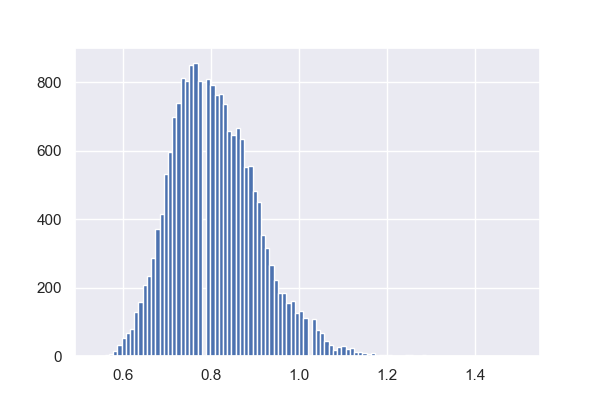

In [176]:
# Draw the histogram
# Variable: P01_TTR_RESISTIVITY

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.hist(df['P01_TTR_RESISTIVITY'], bins=100,)
plt.show()

<IPython.core.display.Javascript object>


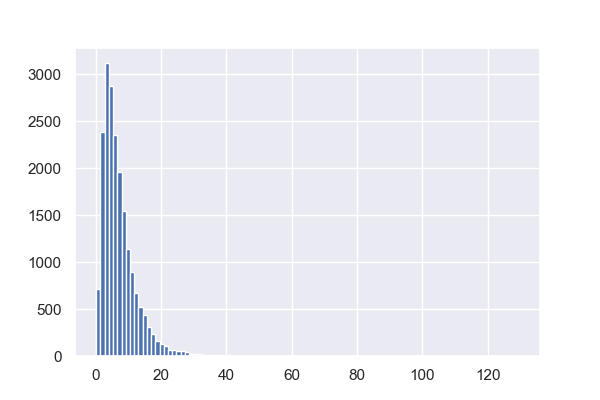

In [169]:
# Draw the histogram
# Variable: P01_TTR_WARP

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.hist(df['P01_TTR_WARP'], bins=100,)
plt.show()

<IPython.core.display.Javascript object>


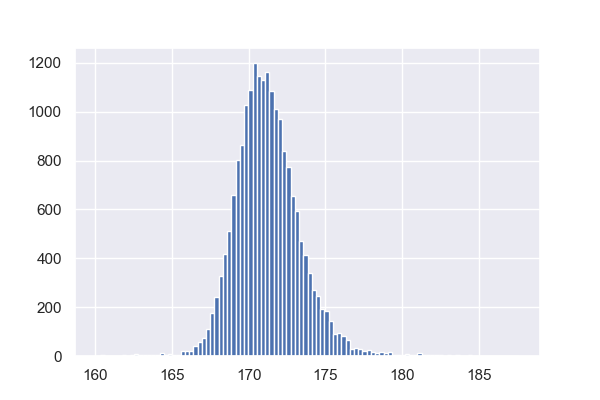

In [178]:
# Draw the histogram
# Variable: ax.hist(df['P01_TTR_AVRTHICKNESS'], bins=100,)

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.hist(df['P01_TTR_AVRTHICKNESS'], bins=100,)
plt.show()

<IPython.core.display.Javascript object>


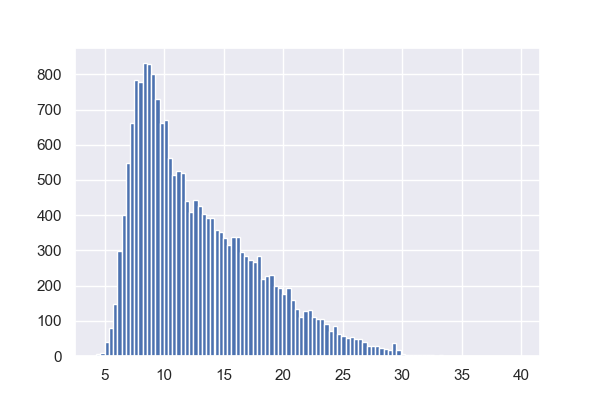

In [179]:
# Draw the histogram
# Variable: P01_TTR_TTV

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.hist(df['P01_TTR_TTV'], bins=100,)
plt.show()

<IPython.core.display.Javascript object>


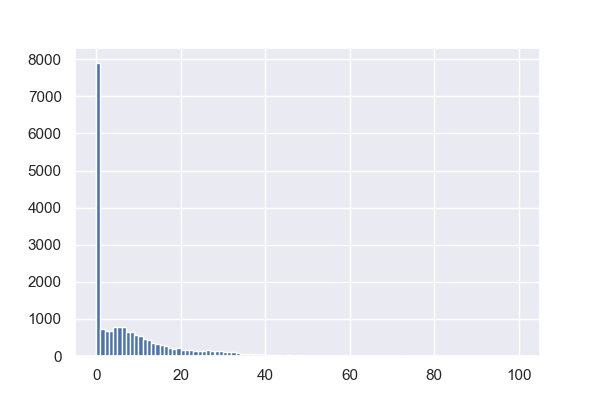

In [181]:
# Draw the histogram
# Variable: P01_PLI_DARKAREAPERCENT

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.hist(df['P01_PLI_DARKAREAPERCENT'], bins=100,)
plt.show()

<IPython.core.display.Javascript object>


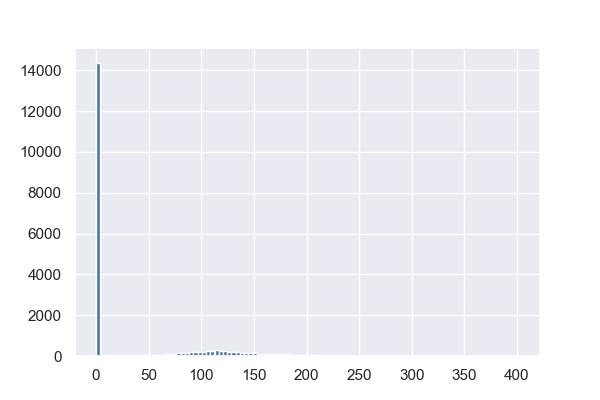

In [173]:
# Draw the histogram
# Variable: P01_PLI_SIGMALIFETIME

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)
ax.hist(df['P01_PLI_SIGMALIFETIME'], bins=100,)
plt.show()

#### (2-2) Split Train & Test dataset

In [33]:
# Split train and test dataset
X = df.drop(columns=['NCELL', 'NCELL2', 'NCELL_Grade'], axis=1)
y = df['NCELL_Grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14000, 8), (6001, 8), (14000,), (6001,))

### (3) Feature Selection

#### (3-1) Remove multicollinear Variables

In [35]:
# Rename features
col_remap = {'P01_TTR_RESISTIVITY':'TTR_RESISTIVITY', 'P01_TTR_WARP':'TTR_WARP',
             'P01_TTR_AVRTHICKNESS':'TTR_AVRTHICKNESS', 'P01_TTR_TTV':'TTR_TTV',
             'P01_PLI_DARKAREAPERCENT':'PLI_DARKAREAPERCENT', 'P01_PLI_SIGMALIFETIME':'PLI_SIGMALIFETIME'}
X_train = X_train.rename(columns=col_remap)
X_test = X_test.rename(columns=col_remap)

<IPython.core.display.Javascript object>


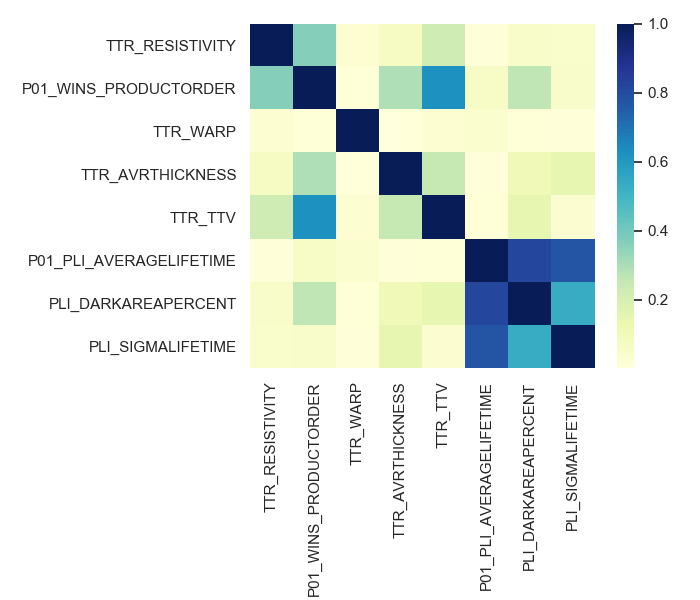

Drop Column List:  []


In [36]:
# Removing highly correlated features

# Filter Method: Spearman's Cross Correlation > 0.90

# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax=ax)
f.tight_layout()
plt.savefig("./img/correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print('Drop Column List: ',to_drop)

# Drop features
X_train_corr = X_train.drop(to_drop, axis = 1)
X_test_corr = X_test.drop(to_drop, axis = 1)

#### (3-2) Scaling

In [38]:
# Scaling
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_corr)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_corr.columns)

X_test_scaled = scaler.fit_transform(X_test_corr)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_corr.columns)

In [39]:
# Sorting dataset
X_train_sorted=X_train.sort_index(ascending=True)
X_train_sorted

,TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,TTR_WARP,TTR_AVRTHICKNESS,TTR_TTV,P01_PLI_AVERAGELIFETIME,PLI_DARKAREAPERCENT,PLI_SIGMALIFETIME
0,0.79,1300712,8.371416,167.011993,8.32,1.29531,1.064450,0.09384
2,0.75,1300728,4.932078,173.442993,16.16,1.38156,8.013530,0.22542
3,0.99,1300728,2.840997,171.082001,13.53,1.25106,21.949989,0.21855
4,0.86,1300728,7.873027,168.774994,15.37,1.26393,15.115940,0.16036
5,0.79,1300728,1.952345,172.098999,9.62,1.31312,14.742320,0.24229
...,...,...,...,...,...,...,...,...
19995,0.78,1300728,8.208883,171.468002,9.18,1.34833,11.470350,0.19591
19996,0.77,1300728,23.576420,171.057999,11.28,1.30165,13.361170,0.21112
19997,0.83,1300728,10.511500,173.757004,15.32,1.38915,7.165320,0.23753
19998,1.01,1300728,4.005659,173.052002,13.09,1.30880,9.833060,0.25044


In [40]:
X_train_scaled

,TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,TTR_WARP,TTR_AVRTHICKNESS,TTR_TTV,P01_PLI_AVERAGELIFETIME,PLI_DARKAREAPERCENT,PLI_SIGMALIFETIME
0,0.310811,0.2,0.040794,0.377895,0.064979,0.605367,0.000000,0.299128
1,0.324324,0.2,0.025481,0.466953,0.048101,0.000134,0.227920,0.000182
2,0.270270,0.2,0.112293,0.383674,0.180872,0.627140,0.000000,0.381208
3,0.243243,0.2,0.019687,0.350569,0.140928,0.502812,0.000000,0.305710
4,0.378378,0.0,0.117345,0.428030,0.204501,0.338670,0.000000,0.210853
...,...,...,...,...,...,...,...,...
13995,0.108108,1.0,0.070474,0.465077,0.268917,0.501854,0.000000,0.321700
13996,0.608108,0.2,0.019397,0.390792,0.260197,0.000204,0.189750,0.000394
13997,0.472973,0.2,0.119242,0.370470,0.104079,0.000202,0.048997,0.000258
13998,0.567568,0.2,0.081988,0.502584,0.219409,0.000215,0.019757,0.000237


#### (3-3) Best Subset Selection using linear regression

In [41]:
# Best Subset Selection 
def fit_linear_reg(X,y):
    # Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,y)
    RSS = mean_squared_error(y, model_k.predict(X)) * len(y)
    R_squared = model_k.score(X,y)
    
    return RSS, R_squared

##### (3-3-1)  Caculate RSS/R-sqiared  loping over all combination or variables

In [42]:
# Initialization variables
k = 6
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

# Looping over k = 1 to 6 features in X
for k in tnrange(1,len(X_train_scaled.columns) + 1, desc = 'Loop...'):
    # Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X_train_scaled.columns, k):
        tmp_result = fit_linear_reg(X_train_scaled[list(combo)], y_train)   
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

# Store in DataFrame
result = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

c:\python37\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


In [43]:
# Minimum and Maximum of RSS values
rss_min = result[result.groupby('numb_features')['RSS'].transform(min) == result['RSS']]
rss_max = result[result.groupby('numb_features')['R_squared'].transform(max) == result['R_squared']]
display(rss_min.head(3))
display(rss_max.head(3))

,numb_features,RSS,R_squared,features
5,1,5587.377198,0.007771,"(P01_PLI_AVERAGELIFETIME,)"
17,2,5553.203183,0.013840,"(P01_WINS_PRODUCTORDER, TTR_TTV)"
66,3,5535.024541,0.017068,"(P01_WINS_PRODUCTORDER, TTR_TTV, P01_PLI_AVERA..."


,numb_features,RSS,R_squared,features
5,1,5587.377198,0.007771,"(P01_PLI_AVERAGELIFETIME,)"
17,2,5553.203183,0.013840,"(P01_WINS_PRODUCTORDER, TTR_TTV)"
66,3,5535.024541,0.017068,"(P01_WINS_PRODUCTORDER, TTR_TTV, P01_PLI_AVERA..."


In [44]:
# Add columns : Minimum RSS, Maximum R-squared
result['min_RSS'] = result.groupby('numb_features')['RSS'].transform(min)
result['max_R_squared'] = result.groupby('numb_features')['R_squared'].transform(max)
result.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,5607.062764,0.004275,"(TTR_RESISTIVITY,)",5587.377198,0.007771
1,1,5589.437707,0.007405,"(P01_WINS_PRODUCTORDER,)",5587.377198,0.007771
2,1,5630.318786,0.000145,"(TTR_WARP,)",5587.377198,0.007771
3,1,5630.236397,0.000160,"(TTR_AVRTHICKNESS,)",5587.377198,0.007771
4,1,5630.951826,0.000033,"(TTR_TTV,)",5587.377198,0.007771


<IPython.core.display.Javascript object>


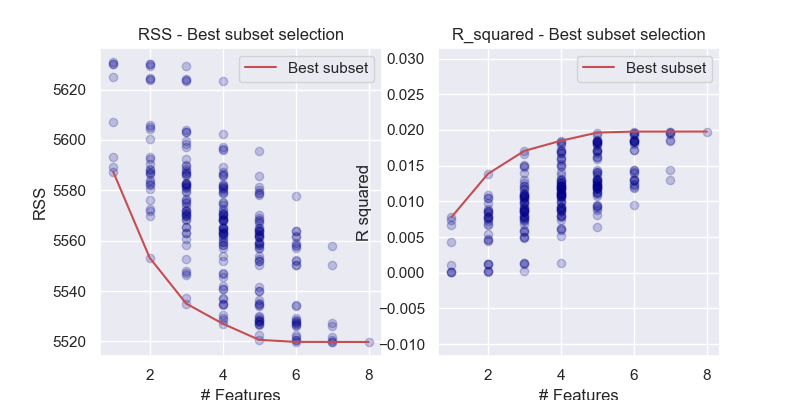

In [45]:
# Ploting for looping results
fig = plt.figure(figsize= (8,4))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(result.numb_features, result.RSS, alpha=0.2, color='darkblue' )
ax.plot(result.numb_features, result.min_RSS,color='r', label='Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(result.numb_features, result.R_squared, alpha=0.2, color='darkblue' )
ax.plot(result.numb_features, result.max_R_squared, color='r', label='Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

##### (3-3-2) Comparing Features Using AIC, BIC, Mallows'CP

In [29]:
# Comparing result of RSS and R_squred value
#result_cp = pd.concat([pd.DataFrame({'features':result['features']}),
#                        pd.DataFrame({'RSS':result['RSS'], 'R_squared': result['R_squared']}),
#                        axis=1, join='inner')
#result_cp['numb_features'] = result_cp.index
#result_cp.head()

In [46]:
# Initializing useful variables
result_cp = result.copy()
m = len(y_train)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(result_cp['RSS'])

# Computing prediction errors : Cp, AIC, BIC, R-squared
result_cp['C_p'] = (1/m) * (result_cp['RSS'] + 2 * result_cp['numb_features'] * hat_sigma_squared )
result_cp['AIC'] = (1/(m*hat_sigma_squared)) * (result_cp['RSS'] + 2 * result_cp['numb_features'] * hat_sigma_squared )
result_cp['BIC'] = (1/(m*hat_sigma_squared)) * (result_cp['RSS'] +  np.log(m) * result_cp['numb_features'] * hat_sigma_squared )
result_cp['R_squared_adj'] = 1 - ( (1 - result_cp['R_squared'])*(m-1)/(m-result_cp['numb_features'] -1))
result_cp.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj
0,1,5607.062764,0.004275,"(TTR_RESISTIVITY,)",5587.377198,0.007771,0.400561,1.015086,1.015625,0.004204
1,1,5589.437707,0.007405,"(P01_WINS_PRODUCTORDER,)",5587.377198,0.007771,0.399302,1.011896,1.012435,0.007334
2,1,5630.318786,0.000145,"(TTR_WARP,)",5587.377198,0.007771,0.402222,1.019296,1.019835,0.000074
3,1,5630.236397,0.000160,"(TTR_AVRTHICKNESS,)",5587.377198,0.007771,0.402216,1.019281,1.019820,0.000088
4,1,5630.951826,0.000033,"(TTR_TTV,)",5587.377198,0.007771,0.402267,1.019410,1.019949,-0.000039


In [47]:
# Add columns: minimum Cp, minimum AIC, minimum BIC, maximum R-squared
result_cp['min_Cp'] = result_cp.groupby('numb_features')['C_p'].transform(min)
result_cp['min_AIC'] = result_cp.groupby('numb_features')['AIC'].transform(min)
result_cp['min_BIC'] = result_cp.groupby('numb_features')['BIC'].transform(min)
result_cp['max_adj_R_squared'] = result_cp.groupby('numb_features')['R_squared_adj'].transform(max)
result_cp.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared,C_p,AIC,BIC,R_squared_adj,min_Cp,min_AIC,min_BIC,max_adj_R_squared
0,1,5607.062764,0.004275,"(TTR_RESISTIVITY,)",5587.377198,0.007771,0.400561,1.015086,1.015625,0.004204,0.399155,1.011523,1.012062,0.0077
1,1,5589.437707,0.007405,"(P01_WINS_PRODUCTORDER,)",5587.377198,0.007771,0.399302,1.011896,1.012435,0.007334,0.399155,1.011523,1.012062,0.0077
2,1,5630.318786,0.000145,"(TTR_WARP,)",5587.377198,0.007771,0.402222,1.019296,1.019835,0.000074,0.399155,1.011523,1.012062,0.0077
3,1,5630.236397,0.000160,"(TTR_AVRTHICKNESS,)",5587.377198,0.007771,0.402216,1.019281,1.019820,0.000088,0.399155,1.011523,1.012062,0.0077
4,1,5630.951826,0.000033,"(TTR_TTV,)",5587.377198,0.007771,0.402267,1.019410,1.019949,-0.000039,0.399155,1.011523,1.012062,0.0077


<IPython.core.display.Javascript object>


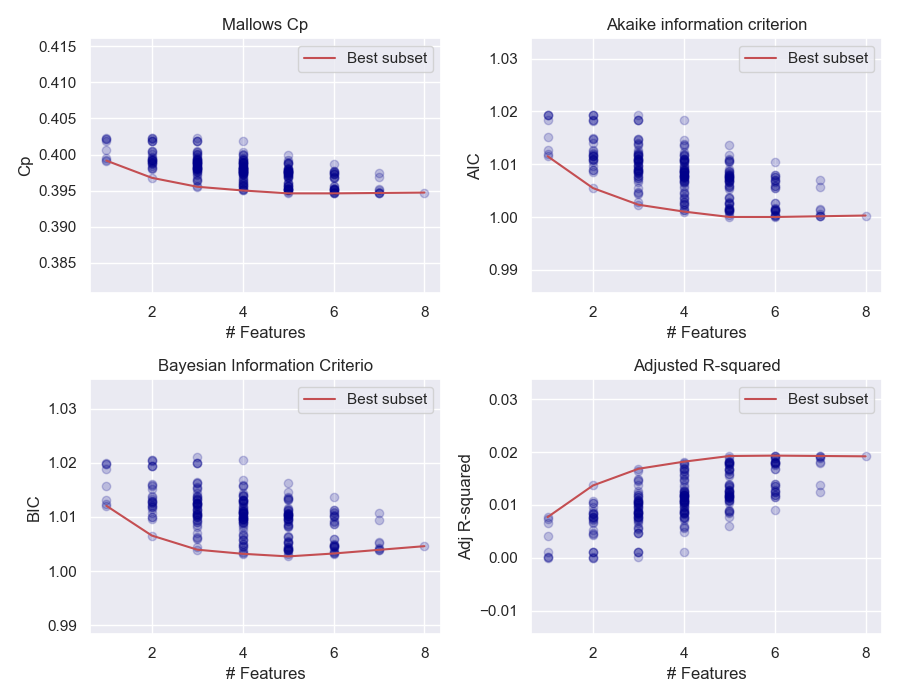

c:\python37\lib\site-packages\ipykernel_launcher.py:40: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


In [48]:
# Ploting for looping results
fig = plt.figure(figsize = (9, 7), constrained_layout=True)

# Plot 1: Mallow's Cp
ax = fig.add_subplot(2, 2, 1)
ax.scatter(result_cp.numb_features, result_cp.C_p, alpha=0.2, color='darkblue' )
ax.plot(result_cp.numb_features, result_cp.min_Cp, color='r', label='Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('Cp')
ax.set_title('Mallows Cp')
ax.legend()

# Plot 2: AIC
ax = fig.add_subplot(2, 2, 2)
ax.scatter(result_cp.numb_features, result_cp.AIC, alpha=0.2, color='darkblue' )
ax.plot(result_cp.numb_features, result_cp.min_AIC, color='r', label='Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('AIC')
ax.set_title('Akaike information criterion')
ax.legend()

# Plot 3: BIC
ax = fig.add_subplot(2, 2, 3)
ax.scatter(result_cp.numb_features, result_cp.BIC, alpha=0.2, color='darkblue' )
ax.plot(result_cp.numb_features, result_cp.min_BIC, color='r', label='Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('BIC')
ax.set_title('Bayesian Information Criterio')
ax.legend()

# Plot 4: Adjusted R-squared
ax = fig.add_subplot(2, 2, 4)
ax.scatter(result_cp.numb_features, result_cp.R_squared_adj, alpha=0.2, color='darkblue' )
ax.plot(result_cp.numb_features, result_cp.max_adj_R_squared, color='r', label='Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('Adj R-squared')
ax.set_title('Adjusted R-squared')
ax.legend()

plt.tight_layout()
plt.savefig('./img/compare_feature.png')
plt.show()

In [49]:
# Best adjusted R-squared
result_cp['C_p'].idxmax(), result_cp['C_p'].max()

(72, 0.40227067867702354)

In [51]:
# Result: Best feature selection
result_cp.iloc[72,:]['features']

('TTR_WARP', 'TTR_AVRTHICKNESS', 'TTR_TTV')

#### (3-4) Recursive Feature Elimination

In [35]:
# Recursive Feature Elimination using linear regression
num_feats = None    # 
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=num_feats, step=10)
rfe_selector = rfe_selector.fit(X_train_scaled, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_scaled.loc[:,rfe_support].columns.tolist()
print(rfe_feature, 'selected features')

['P01_TTR_RESISTIVITY', 'P01_TTR_AVRTHICKNESS', 'P01_PLI_SIGMALIFETIME'] selected features


#### (3-5) Logistic Regression

In [53]:
# Feature Selection using Logistic Regression
num_feats = None
embeded_lr_selector = SelectFromModel(LogisticRegression(solver='liblinear',penalty="l2", tol=0.01), max_features=num_feats)
embeded_lr_selector.fit(X_train_scaled, y_train)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train_scaled.loc[:,embeded_lr_support].columns.tolist()
print((embeded_lr_feature), 'selected features')

['P01_WINS_PRODUCTORDER', 'TTR_AVRTHICKNESS', 'TTR_TTV', 'P01_PLI_AVERAGELIFETIME'] selected features


#### (3-6) Random Forest Classifier

In [36]:
# Get Best hyperparamters of Random Forest
best_param_rf = getBestHyperParam(x=X_train_scaled, y=y_train, classifier="Random Forest")
print(best_param_rf)

Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min


KeyboardInterrupt: 

In [237]:
# Choose Best Parameters usign Random Forest
best_feature_rf = getBestFeat(x=X_train_scaled, y=y_train, params=best_param_rf)
print(best_feature_rf, 'selected features')

['P01_TTR_WARP', 'P01_TTR_AVRTHICKNESS', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME'] selected features


In [253]:
# Get Feature Infortance
getFeatImpt(x_train=X_train_scaled, x_test=X_test_scaled, y_train=y_train, 
            params=best_param_rf, feature=best_feature_rf, saveTag='rf')

#### (3-7) Extra Tree Ensemble Classifier

In [247]:
# Get Best hyperparamters of Extra Trees Ensemble
best_param_ete = getBestHyperParam(x=X_train_scaled, y=y_train, classifier="Extra Trees Ensemble")
print(best_param_ete)

Now tuning Extra Trees Ensemble. Go grab a beer or something.
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.1min finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=7, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=0.01, min_samples_split=0.05,
                     min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [248]:
# Choose Best Parameters using Extra Trees Ensemble
best_feature_ete = getBestFeat(x=X_train_scaled, y=y_train, params=best_param_ete)
print(best_feature_ete, 'selected features')

['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME'] selected features


<IPython.core.display.Javascript object>


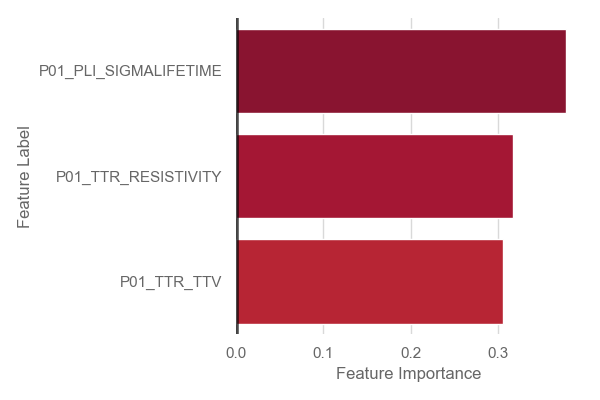

In [251]:
# Get Feature Infortance
getFeatImpt(x_train=X_train_scaled, x_test=X_test_scaled, y_train=y_train, 
            params=best_param_ete, feature=best_feature_ete, saveTag='ete')

#### (3-8) Decision Tree Classifier

In [111]:
# Get Best hyperparamters of Decision Tree Classifier
best_param_dtc = getBestHyperParam(x=X_train_scaled, y=y_train, classifier="DTC")
print(best_param_dtc)

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   27.7s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=17, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:   32.1s finished


In [114]:
# Choose Best Parameters
best_feature_dtc = getBestFeat(x=X_train_scaled, y=y_train, params=best_param_dtc)
print(best_feature_dtc, 'selected features')

['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_DARKAREAPERCENT'] selected features


<IPython.core.display.Javascript object>


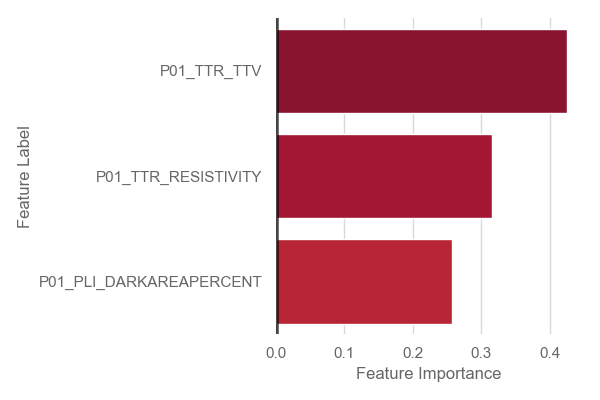

In [117]:
# Get Feature Infortance
getFeatImpt(x_train=X_train_scaled, x_test=X_test_scaled, y_train=y_train, 
            params=best_param_dtc, feature=best_feature_dtc, saveTag='dtc')

#### (3-9) Best Feature Selection

In [80]:
# Comaparing 
best_feat1 = ['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']
best_feat2 = ['P01_TTR_RESISTIVITY', 'P01_PLI_DARKAREAPERCENT', 'P01_PLI_SIGMALIFETIME']
best_feat3 = ['P01_TTR_RESISTIVITY', 'P01_TTR_WARP', 'P01_TTR_AVRTHICKNESS', 'P01_TTR_TTV', 'P01_PLI_DARKAREAPERCENT', 'P01_PLI_SIGMALIFETIME']
best_feat4 = ['P01_TTR_WARP', 'P01_TTR_AVRTHICKNESS', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']
best_feat5 = ['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']
best_feat6 = ['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_DARKAREAPERCENT']
best_feat7 = ['P01_TTR_RESISTIVITY', 'P01_TTR_WARP', 'P01_TTR_AVRTHICKNESS', 'P01_TTR_TTV', 'P01_PLI_DARKAREAPERCENT', 'P01_PLI_SIGMALIFETIME']

best_feat_list = [best_feat1, best_feat2, best_feat3, best_feat4, best_feat5, best_feat6, best_feat7]

best_feat_cnt = {}
for best_feats in best_feat_list:
    for best_feat in best_feats:
        if best_feat not in best_feat_cnt.keys():
            best_feat_cnt.update({best_feat : 1})
        else:
            best_feat_cnt.update({best_feat : best_feat_cnt[best_feat] + 1})

best_feat_cnt_sorted = {k: v for k, v in sorted(best_feat_cnt.items(), key=lambda item: item[1], reverse=True)}

for item in  best_feat_cnt_sorted.items():
    print("Variable: {}  /  Count: {}".format(item[0], item[1]))

Variable: P01_TTR_RESISTIVITY  /  Count: 6
Variable: P01_TTR_TTV  /  Count: 6
Variable: P01_PLI_SIGMALIFETIME  /  Count: 6
Variable: P01_PLI_DARKAREAPERCENT  /  Count: 4
Variable: P01_TTR_WARP  /  Count: 3
Variable: P01_TTR_AVRTHICKNESS  /  Count: 3


### (4) Modeling

#### (4-1) Best Feature Selection

Feature: P01_TTR_RESISTIVITY / P01_TTR_TTV / P01_PLI_SIGMALIFETIME

In [1]:
# Select Best Features
best_feat = ['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']
X_train_best1 = X_train[best_feat]
X_test_best1 = X_test[best_feat]
X_train_best1.shape, X_test_best1.shape

NameError: name 'X_train' is not defined

In [329]:
# Hyperparameter Tuning of "Random Forest"
best_param_rf = getBestHyperParam(x=X_train_best1, y=y_train, classifier='Random Forest')

Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.0min finished


In [337]:
# Modeliing and Getting Results of "Random Forest"
rf = best_param_rf
rf.fit(X_train_best1, y_train)
rf_pred = rf.predict(X_test_best1)
rf_score = accuracy_score(y_test, rf_pred)
print('Accuracy Rate: {0:.2f}%'.format(rf_score * 100))

Accuracy Rate: 77.85%


In [332]:
# Hyperparameter Tuning of "Extra Trees Ensemble"
best_param_ete = getBestHyperParam(x=X_train_best1, y=y_train, classifier='Extra Trees Ensemble')

Now tuning Extra Trees Ensemble. Go grab a beer or something.
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  3.8min finished


In [338]:
# Modeliing and Getting Results of "Extra Trees Ensemble"
ete = best_param_ete
ete.fit(X_train_best1, y_train)
ete_pred = ete.predict(X_test_best1)
ete_score = accuracy_score(y_test, ete_pred)
print('Accuracy Rate: {0:.2f}%'.format(ete_score * 100))

Accuracy Rate: 77.85%


In [339]:
# Hyperparameter Tuning of "Decision Tree Classifier"
best_param_dtc = getBestHyperParam(x=X_train_best1, y=y_train, classifier='DTC')

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 2048 candidates, totalling 10240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 10200 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 10240 out of 10240 | elapsed:   40.8s finished


In [120]:
# Modeliing and Getting Results of "Decision Tree Classifier"
dtc = best_param_dtc
dtc.fit(X_train_best1, y_train)
dtc_pred = dtc.predict(X_test_best1)
dtc_score = accuracy_score(y_test, dtc_pred)
print('Accuracy Rate: {0:.2f}%'.format(dtc_score * 100))

Accuracy Rate: 77.85%


In [360]:
# Camparing test output vs predicted value
com_dtc = pd.DataFrame({'y_test': y_test.tolist(),
                        'dtc_pred': list(dtc_pred)})
com_dtc.head()
com_dtc.to_csv('./result/rslt_com_dtc.csv')

In [341]:
# Hyperparameter Tuning of "Mulit-Layer Perceptron"
best_param_mlp = getBestHyperParam(x=X_train_best1, y=y_train, classifier='MLP')

Now tuning MLP. Go grab a beer or something.
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.5min finished


In [342]:
# Modeliing and Getting Results of ""Mulit-Layer Perceptron"
mlp = best_param_mlp
mlp.fit(X_train_best1, y_train)
mlp_pred = mlp.predict(X_test_best1)
mlp_score = accuracy_score(y_test, mlp_pred)
print('Accuracy Rate: {0:.2f}%'.format(mlp_score * 100))

Accuracy Rate: 77.85%


## Analysis Method 2

In [28]:
# Load dataset
df2 = pd.read_csv("./data/wafer_Inspection.csv")
df2['NCELL2'] = df2['NCELL']* 100
df2.loc[df['NCELL'] < 0.2, 'NCELL_Grade'] = 1
df2.loc[(df['NCELL'] >= 0.2) & (df2['NCELL'] < 0.22), 'NCELL_Grade'] = 2
df2.loc[df['NCELL'] >= 0.22, 'NCELL_Grade'] = 3
df2['NCELL_Grade'] = df2['NCELL_Grade'].astype(int)

# These columns uniquly have 0 value
df2.drop(columns=['P01_PLI_DEFECTAREAPERCENT','P01_PLI_DEFECTAVERAGE','P01_PLI_GRAINDEFECTAREAPERCENT',
                 'P01_PLI_EFFICIENCY','P01_PLI_RELATIVEEFFICIENCY'], axis=1, inplace=True)

# These columns uniquly have 0 value
df2.drop(columns=['P01_WINS_PRODUCTORDER', 'P01_WINS_CLASS'], axis=1, inplace=True)
df2.drop(columns=['NCELL', 'NCELL2'], axis=1, inplace=True)
df2.head()

,P01_TTR_RESISTIVITY,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_SIGMALIFETIME,NCELL_Grade
0,0.79,8.371416,167.011993,8.32,1.29531,1.064450,0.09384,3
1,0.73,3.696186,171.750000,10.27,1.36469,7.455840,0.22093,3
2,0.75,4.932078,173.442993,16.16,1.38156,8.013530,0.22542,2
3,0.99,2.840997,171.082001,13.53,1.25106,21.949989,0.21855,3
4,0.86,7.873027,168.774994,15.37,1.26393,15.115940,0.16036,2


In [89]:
# Correaltion of input & output variables
df2.corr()

,P01_TTR_RESISTIVITY,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_SIGMALIFETIME,NCELL_Grade
P01_TTR_RESISTIVITY,1.000000,0.029744,0.106774,0.243983,-0.163051,-0.020260,-0.139640,-0.064034
P01_TTR_WARP,0.029744,1.000000,0.016807,0.058189,-0.021640,-0.050629,-0.013330,0.009802
P01_TTR_AVRTHICKNESS,0.106774,0.016807,1.000000,0.262448,-0.196264,0.000638,-0.198004,0.005878
P01_TTR_TTV,0.243983,0.058189,0.262448,1.000000,-0.235638,0.012792,-0.208548,0.002424
P01_PLI_AVERAGELIFETIME,-0.163051,-0.021640,-0.196264,-0.235638,1.000000,-0.454817,0.949391,0.085130
P01_PLI_DARKAREAPERCENT,-0.020260,-0.050629,0.000638,0.012792,-0.454817,1.000000,-0.435283,-0.033460
P01_PLI_SIGMALIFETIME,-0.139640,-0.013330,-0.198004,-0.208548,0.949391,-0.435283,1.000000,0.076457
NCELL_Grade,-0.064034,0.009802,0.005878,0.002424,0.085130,-0.033460,0.076457,1.000000


<IPython.core.display.Javascript object>


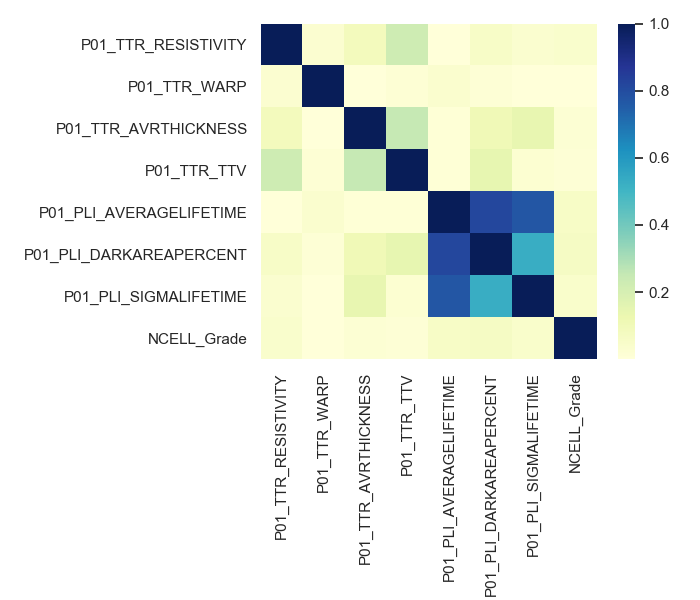

In [29]:
# Make correlation matrix
corr_matrix = df2.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()

plt.savefig("./img/corr_matrix_output.png", dpi = 1080)

#### Data Transformation

In [30]:
# Additional Feature Engineering
df2 = df2[['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME', 'NCELL_Grade']]

# squred root transform
df2['P01_PLI_SIGMALIFETIME'] = np.sqrt(df2['P01_PLI_SIGMALIFETIME'])

In [31]:
# Train and Test Split
X2 = df2.drop(['NCELL_Grade'], axis=1)
y2 = df2['NCELL_Grade']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=2020)

In [74]:
# Scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()

X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.fit_transform(X_test2)

X_train2_scaled = pd.DataFrame(X_train2_scaled, columns=X_train2.columns)
X_test2_scaled = pd.DataFrame(X_test2_scaled, columns=X_test2.columns)

In [75]:
# Hyperparameter Tuning of "Decision Tree Classifier"
best_param_dtc2 = getBestHyperParam(x=X_train2_scaled, y=y_train2, classifier="DTC")
print(best_param_dtc2)

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   22.4s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=13, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:   23.4s finished


In [76]:
# Modeliing and Getting Results of "Decision Tree Classifier"
dtc2 = best_param_dtc2
dtc2.fit(X_train2_scaled, y_train2)
dtc2_pred = dtc2.predict(X_test2_scaled)
dtc2_score = accuracy_score(y_test2, dtc2_pred)
print('Accuracy Rate: {0:.2f}%'.format(dtc2_score * 100))

Accuracy Rate: 77.85%


In [54]:
# Save test output and predicted result
com_dtc2 = pd.DataFrame({'y_test': y_test2.tolist(),'dtc_pred': list(dtc2_pred)})
com_dtc2.to_csv('./result/rslt_com_dtc2.csv')

In [ ]:
# Hyperparameter Tuning of "Random Forest"
best_param_rf2 = getBestHyperParam(x=X_train2_scaled, y=y_train2, classifier='Random Forest')

In [ ]:
# Modeliing and Getting Results of "Random Forest"
rf2 = best_param_rf2
rf2.fit(X_train2_scaled, y_train2)
rf2_pred = rf2.predict(X_test2_scaled)
rf2_score = accuracy_score(y_test2, rf2_pred)
print('Accuracy Rate: {0:.2f}%'.format(rf2_score * 100))

In [ ]:
# Save test output and predicted result
com_rf2 = pd.DataFrame({'y_test': y_test2.tolist(),'rf2_pred': list(rf2_pred)})
com_rf2.to_csv('./result/rslt_com_rf2.csv')

In [ ]:
# Hyperparameter Tuning of "Extra Trees Ensemble"
best_param_ete2 = getBestHyperParam(x=X_train2_scaled, y=y_train2, classifier='Extra Trees Ensemble')

In [ ]:
# Modeliing and Getting Results of "Extra Trees Ensemble"
ete2 = best_param_ete2
ete2.fit(X_train2_scaled, y_train2)
ete2_pred = ete2.predict(X_test2_scaled)
ete2_score = accuracy_score(y_test2, ete2_pred)
print('Accuracy Rate: {0:.2f}%'.format(ete2_score * 100))

In [ ]:
# Save test output and predicted result
com_ete2 = pd.DataFrame({'y_test': y_test2.tolist(),'ete2_pred': list(ete2_pred)})
com_ete2.to_csv('./result/rslt_com_ete2.csv')

## Analysis Method 3

In [121]:
# Add additional features
df3 = pd.read_csv("./data/wafer_Inspection.csv")
df3['NCELL2'] = df3['NCELL']* 100
df3.loc[df['NCELL'] < 0.2, 'NCELL_Grade'] = 1
df3.loc[(df['NCELL'] >= 0.2) & (df3['NCELL'] < 0.22), 'NCELL_Grade'] = 2
df3.loc[df['NCELL'] >= 0.22, 'NCELL_Grade'] = 3
df3['NCELL_Grade'] = df3['NCELL_Grade'].astype(int)

# Drop features that have only 0
df3.drop(columns=['P01_PLI_DEFECTAREAPERCENT','P01_PLI_DEFECTAVERAGE','P01_PLI_GRAINDEFECTAREAPERCENT',
                 'P01_PLI_EFFICIENCY','P01_PLI_RELATIVEEFFICIENCY'], axis=1, inplace=True)

# Drop features that have extreamely unbalanced data
df3.drop(columns=['P01_WINS_PRODUCTORDER', 'P01_WINS_CLASS'], axis=1, inplace=True)

# Drop unnecessary features 
df3.drop(columns=['NCELL', 'NCELL2'], axis=1, inplace=True)
df3.head()

,P01_TTR_RESISTIVITY,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_SIGMALIFETIME,NCELL_Grade
0,0.79,8.371416,167.011993,8.32,1.29531,1.064450,0.09384,3
1,0.73,3.696186,171.750000,10.27,1.36469,7.455840,0.22093,3
2,0.75,4.932078,173.442993,16.16,1.38156,8.013530,0.22542,2
3,0.99,2.840997,171.082001,13.53,1.25106,21.949989,0.21855,3
4,0.86,7.873027,168.774994,15.37,1.26393,15.115940,0.16036,2


### Outlier Clipping

In [176]:
X3 = df3.drop(['NCELL_Grade'], axis=1)
y3 = df3['NCELL_Grade']

In [177]:
# Outlier Clipping using percentiles
percentiles = X3.quantile([0.05,0.95]).values
# percentiles = X3.quantile([0.1,0.90]).values
# percentiles = X3.quantile([0.2,0.80]).values
percentiles

array([[7.30000019e-01, 3.16938806e+00, 1.69567001e+02, 8.28999996e+00,
        1.25714004e+00, 0.00000000e+00, 1.20449997e-01],
       [8.89999986e-01, 1.04117403e+01, 1.72783997e+02, 1.71599998e+01,
        9.94654114e+02, 1.39054804e+01, 1.01105987e+02]])

In [178]:
# Each features : percentile range 
clip_dict = {}
for i in range(percentiles.shape[1]):
    percentile = percentiles[:,i]
    clip_dict.update({X3.columns[i]: percentile})
clip_dict

{'P01_TTR_RESISTIVITY': array([0.73000002, 0.88999999]),
 'P01_TTR_WARP': array([ 3.16938806, 10.4117403 ]),
 'P01_TTR_AVRTHICKNESS': array([169.5670013, 172.7839966]),
 'P01_TTR_TTV': array([ 8.28999996, 17.15999985]),
 'P01_PLI_AVERAGELIFETIME': array([  1.25714004, 994.6541138 ]),
 'P01_PLI_DARKAREAPERCENT': array([ 0.        , 13.90548038]),
 'P01_PLI_SIGMALIFETIME': array([  0.12045  , 101.1059875])}

In [179]:
# Percentile Clipping
for i in range(X3.shape[1]):
    for j in range(X3.shape[0]):
        if X3.iloc[j,i] < clip_dict[X3.columns[i]][0]:
            X3.iloc[j,i] = clip_dict[X3.columns[i]][0]
            
        elif X3.iloc[j,i] > clip_dict[X3.columns[i]][1]:
            X3.iloc[j,i] = clip_dict[X3.columns[i]][1]

In [180]:
X3.head()

,P01_TTR_RESISTIVITY,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_SIGMALIFETIME
0,0.79,8.371416,169.567001,8.32,1.29531,1.06445,0.12045
1,0.73,3.696186,171.750000,10.27,1.36469,7.45584,0.22093
2,0.75,4.932078,172.783997,16.16,1.38156,8.01353,0.22542
3,0.89,3.169388,171.082001,13.53,1.25714,13.90548,0.21855
4,0.86,7.873027,169.567001,15.37,1.26393,13.90548,0.16036


In [162]:
# Check the result after applying outlier clipping 
X3['P01_TTR_RESISTIVITY'].min(), X3['P01_TTR_RESISTIVITY'].max()

(0.7300000190000001, 0.889999986)

##### All varibles

In [163]:
# Train and Test Split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=2020)

# Scaling
scaler = MinMaxScaler()
X_train3_scaled = scaler.fit_transform(X_train3)
X_test3_scaled = scaler.fit_transform(X_test3)

# Array to DataFrame
X_train3_scaled = pd.DataFrame(X_train3_scaled, columns=X_train3.columns)
X_test3_scaled = pd.DataFrame(X_test3_scaled, columns=X_test3.columns)

In [164]:
# Hyperparameter Tuning of "Decision Tree Classifier"
best_param_dtc3 = getBestHyperParam(x=X_train3_scaled, y=y_train3, classifier="DTC")
print(best_param_dtc3)

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   27.0s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:   30.9s finished


In [167]:
# Modeliing and Getting Results of "Decision Tree Classifier"
dtc3 = best_param_dtc3
dtc3.fit(X_train3_scaled, y_train3)
dtc3_pred = dtc3.predict(X_test3_scaled)
dtc3_score = accuracy_score(y_test3, dtc3_pred)
print('Accuracy Rate: {0:.2f}%'.format(dtc3_score * 100))

Accuracy Rate: 77.85%


In [ ]:
# Hyperparameter Tuning of "Random Forest"
best_param_rf3 = getBestHyperParam(x=X_train3_scaled, y=y_train3, classifier='Random Forest')

In [ ]:
# Modeliing and Getting Results of "Random Forest"
rf3 = best_param_rf3
rf3.fit(X_train3_scaled, y_train3)
rf3_pred = rf3.predict(X_test3_scaled)
rf3_score = accuracy_score(y_test3, rf3_pred)
print('Accuracy Rate: {0:.3f}%'.format(rf3_score * 100))

In [ ]:
# Hyperparameter Tuning of "Extra Trees Ensemble"
best_param_ete3 = getBestHyperParam(x=X_train3_scaled, y=y_train3, classifier='Extra Trees Ensemble')

In [ ]:
# Modeliing and Getting Results of "Extra Trees Ensemble"
ete3 = best_param_ete3
ete3.fit(X_train3_scaled, y_train3)
ete3_pred = ete3.predict(X_test3_scaled)
ete3_score = accuracy_score(y_test3, ete3_pred)
print('Accuracy Rate: {0:.3f}%'.format(ete3_score * 100))

##### Feature Selected varibles

In [154]:
# Select best features
X_train3_scaled = X_train3_scaled[['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']]
X_test3_scaled = X_test3_scaled[['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']]

In [155]:
# Hyperparameter Tuning of "Decision Tree Classifier"
best_param_dtc3 = getBestHyperParam(x=X_train3_scaled, y=y_train3, classifier="DTC")
print(best_param_dtc3)

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   22.2s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.005, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:   23.2s finished


In [166]:
# Modeliing and Getting Results of "Decision Tree Classifier"
dtc3 = best_param_dtc3
dtc3.fit(X_train3_scaled, y_train3)
dtc3_pred = dtc3.predict(X_test3_scaled)
dtc3_score = accuracy_score(y_test3, dtc3_pred)
print('Accuracy Rate: {0:.2f}%'.format(dtc3_score * 100))

Accuracy Rate: 77.85%


In [ ]:
# Hyperparameter Tuning of "Random Forest"
best_param_rf3 = getBestHyperParam(x=X_train3_scaled, y=y_train3, classifier='Random Forest')

In [ ]:
# Modeliing and Getting Results of "Random Forest"
rf3 = best_param_rf3
rf3.fit(X_train3_scaled, y_train3)
rf3_pred = rf3.predict(X_test3_scaled)
rf3_score = accuracy_score(y_test3, rf3_pred)
print('Accuracy Rate: {0:.3f}%'.format(rf3_score * 100))

In [ ]:
# Hyperparameter Tuning of "Extra Trees Ensemble"
best_param_ete3 = getBestHyperParam(x=X_train3_scaled, y=y_train3, classifier='Extra Trees Ensemble')

In [ ]:
# Modeliing and Getting Results of "Extra Trees Ensemble"
ete3 = best_param_ete3
ete3.fit(X_train3_scaled, y_train3)
ete3_pred = ete3.predict(X_test3_scaled)
ete3_score = accuracy_score(y_test3, ete3_pred)
print('Accuracy Rate: {0:.3f}%'.format(ete3_score * 100))

## Analysis Method 4

In [246]:
df4 = pd.read_csv("./data/wafer_Inspection.csv")
df4['NCELL2'] = df4['NCELL']* 100
df4.loc[df['NCELL'] < 0.2, 'NCELL_Grade'] = 0
df4.loc[(df['NCELL'] >= 0.2) & (df4['NCELL'] < 0.22), 'NCELL_Grade'] = 1
df4.loc[df['NCELL'] >= 0.22, 'NCELL_Grade'] = 2
#df4['NCELL_Grade'] = df4['NCELL_Grade'].astype(int)

# These columns uniquly have 0 value
df4.drop(columns=['P01_PLI_DEFECTAREAPERCENT','P01_PLI_DEFECTAVERAGE','P01_PLI_GRAINDEFECTAREAPERCENT',
                 'P01_PLI_EFFICIENCY','P01_PLI_RELATIVEEFFICIENCY'], axis=1, inplace=True)

# These columns uniquly have 0 value
df4.drop(columns=['P01_WINS_PRODUCTORDER', 'P01_WINS_CLASS'], axis=1, inplace=True)
df4.drop(columns=['NCELL', 'NCELL2'], axis=1, inplace=True)

X4 = df4.drop(['NCELL_Grade'], axis=1)
y4 = df4['NCELL_Grade']

# Train and Test Split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=2020)

# Scaling
scaler = MinMaxScaler()
X_train4_scaled = scaler.fit_transform(X_train4)
X_test4_scaled = scaler.fit_transform(X_test4)

# Array to DataFrame
X_train4_scaled = pd.DataFrame(X_train4_scaled, columns=X_train4.columns)
X_test4_scaled = pd.DataFrame(X_test4_scaled, columns=X_test4.columns)

# y_train4_bn = label_binarize(y_train4, classes=[1, 2, 3])
# y_test4_bn = label_binarize(y_test4, classes=[1, 2, 3])

In [247]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data, num_classes=3)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

def decode(datum):
    return np.argmax(datum)

for i in range(encoded_data.shape[0]):
    datum = encoded_data[i]
    print('index: %d' % i)
    print('encoded datum: %s' % datum)
    decoded_datum = decode(encoded_data[i])
    print('decoded datum: %s' % decoded_datum)

In [248]:
y_train4_encoded = to_categorical(y_train4.tolist(), num_classes=3)
y_test4_encoded = to_categorical(y_test4.tolist(), num_classes=3)

In [335]:
# Multi Perceptron Model
n_cols = X_train4_scaled.shape[1]

model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', input_shape=(n_cols,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(3, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train4_scaled.to_numpy(), y_train4_encoded, 
          epochs=20, verbose=False, batch_size=128)

train_loss, train_acc = model.evaluate(X_train4_scaled, y_train4_encoded, verbose=2)
test_loss, test_acc = model.evaluate(X_test4_scaled, y_test4_encoded, verbose=2)

14000/14000 - 1s - loss: 0.4135 - acc: 0.8420
6001/6001 - 0s - loss: 0.4024 - acc: 0.8524


In [324]:
model.evaluate(X_test4_scaled, y_test4, verbose=2)

6001/6001 - 0s - loss: 2.3261 - acc: 0.1034


[2.3261009241179456, 0.1034272]

In [314]:
model.predict(X_test4_scaled)

array([[0.02086636, 0.19954562, 0.8037496 ],
       [0.0483675 , 0.11136284, 0.82656705],
       [0.12167919, 0.13306147, 0.73908436],
       ...,
       [0.07658333, 0.05656117, 0.86030185],
       [0.09647363, 0.12181357, 0.78371626],
       [0.04428279, 0.25099313, 0.7119776 ]], dtype=float32)

In [315]:
pred_org = pd.DataFrame(data=model.predict(X_test4_scaled), columns=['1','2','3'])
pred_org.head()

,1,2,3
0,0.020866,0.199546,0.803750
1,0.048368,0.111363,0.826567
2,0.121679,0.133061,0.739084
3,0.022329,0.144179,0.838412
4,0.033071,0.184286,0.782485


In [288]:
encoded_rslt = np.around(model.predict(X_test4_scaled))

In [309]:
pred_rslt = []
for i in range(encoded_rslt.shape[0]):
    datum = encoded_rslt[i]
    #print('encoded datum: %s' % datum)
    decoded_datum = decode(encoded_rslt[i]) + 1
    pred_rslt.append(decoded_datum)
    #print('decoded datum: %s' % decoded_datum)
len(pred_rslt)

6001

In [321]:
rslt = pd.DataFrame(data=(y_test4+1).to_list(), columns=['y_test_real'])
rslt['y_test_real'] = rslt['y_test_real'].astype(int)
rslt['y_test_pred'] = pred_rslt
rslt_final = pd.concat([rslt, pred_org], axis=1)
rslt_final.to_csv('./result/mlp_model_1.csv')
rslt_final.head()

,y_test_real,y_test_pred,1,2,3
0,3,3,0.020866,0.199546,0.803750
1,3,3,0.048368,0.111363,0.826567
2,3,3,0.121679,0.133061,0.739084
3,3,3,0.022329,0.144179,0.838412
4,3,3,0.033071,0.184286,0.782485


In [332]:
# Multi Perceptron Model

X_train4_scaled_2 = X_train4_scaled[['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']]
X_test4_scaled_2 = X_test4_scaled[['P01_TTR_RESISTIVITY', 'P01_TTR_TTV', 'P01_PLI_SIGMALIFETIME']]

n_cols = X_train4_scaled_2.shape[1]

model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', input_shape=(n_cols,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(3, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train4_scaled_2.to_numpy(), y_train4_encoded, 
          epochs=20, verbose=False, batch_size=256)

train_loss, train_acc = model.evaluate(X_train4_scaled_2, y_train4_encoded, verbose=2)
test_loss, test_acc = model.evaluate(X_test4_scaled_2, y_test4_encoded, verbose=2)

14000/14000 - 1s - loss: 0.4190 - acc: 0.8420
6001/6001 - 0s - loss: 0.4056 - acc: 0.8524


### Output Analysis

#### 3D Scatter Plot

In [339]:
df = pd.read_csv("./data/wafer_Inspection.csv")
df.head()

,NCELL,P01_TTR_RESISTIVITY,P01_WINS_PRODUCTORDER,P01_WINS_CLASS,P01_TTR_WARP,P01_TTR_AVRTHICKNESS,P01_TTR_TTV,P01_PLI_AVERAGELIFETIME,P01_PLI_DARKAREAPERCENT,P01_PLI_DEFECTAREAPERCENT,P01_PLI_DEFECTAVERAGE,P01_PLI_GRAINDEFECTAREAPERCENT,P01_PLI_EFFICIENCY,P01_PLI_RELATIVEEFFICIENCY,P01_PLI_SIGMALIFETIME
0,0.220886,0.79,1300712,Good,8.371416,167.011993,8.32,1.29531,1.064450,0,0,0,0,0,0.09384
1,0.222100,0.73,1300728,Good,3.696186,171.750000,10.27,1.36469,7.455840,0,0,0,0,0,0.22093
2,0.218838,0.75,1300728,Good,4.932078,173.442993,16.16,1.38156,8.013530,0,0,0,0,0,0.22542
3,0.223447,0.99,1300728,Good,2.840997,171.082001,13.53,1.25106,21.949989,0,0,0,0,0,0.21855
4,0.214146,0.86,1300728,Good,7.873027,168.774994,15.37,1.26393,15.115940,0,0,0,0,0,0.16036


<IPython.core.display.Javascript object>


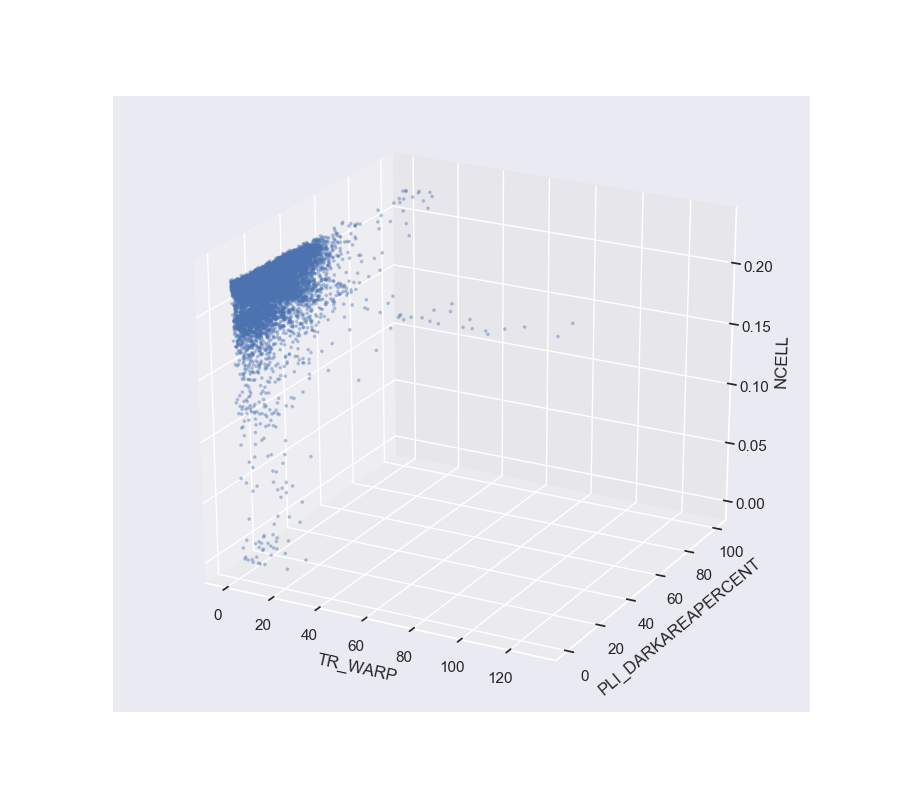

In [350]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(1,1,1, projection='3d')

xs = df['P01_TTR_WARP']
ys = df['P01_PLI_DARKAREAPERCENT']
zs = df['NCELL']
ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=3)

ax.set_xlabel("TR_WARP")
ax.set_ylabel("PLI_DARKAREAPERCENT")
ax.set_zlabel("NCELL")

plt.show()

#### Decision Tree

In [6]:
df5 = pd.read_csv("./data/wafer_Inspection.csv")
df5.head()

df5['NCELL2'] = df5['NCELL']* 100
df5.loc[df5['NCELL'] < 0.2, 'NCELL_Grade'] = 0
df5.loc[(df5['NCELL'] >= 0.2) & (df5['NCELL'] < 0.22), 'NCELL_Grade'] = 0
df5.loc[df5['NCELL'] >= 0.22, 'NCELL_Grade'] = 1

# Remove unnecessary columns
df5.drop(columns=['P01_PLI_DEFECTAREAPERCENT','P01_PLI_DEFECTAVERAGE','P01_PLI_GRAINDEFECTAREAPERCENT',
                 'P01_PLI_EFFICIENCY','P01_PLI_RELATIVEEFFICIENCY'], axis=1, inplace=True)

df5.drop(columns=['P01_WINS_PRODUCTORDER', 'P01_WINS_CLASS'], axis=1, inplace=True)

X5 = df5.drop(['NCELL', 'NCELL2'], axis=1)
y5 = df5['NCELL_Grade']

# Train / Test Split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.3, random_state=2020)

# Scaling
scaler = MinMaxScaler()
X_train5_scaled = scaler.fit_transform(X_train5)
X_test5_scaled = scaler.fit_transform(X_test5)

X_train5_scaled = pd.DataFrame(X_train5_scaled, columns=X_train5.columns)
X_test5_scaled = pd.DataFrame(X_test5_scaled, columns=X_test5.columns)

# Feature Selection

# case1 : TTR_WARP
X_train5_WARP = pd.DataFrame(X_train5_scaled['P01_TTR_WARP'], columns=['P01_TTR_WARP'])
X_test5_WARP = pd.DataFrame(X_test5_scaled['P01_TTR_WARP'], columns=['P01_TTR_WARP'])

# case2 : PLI_DARKAREAPERCENT
X_train5_DAP = pd.DataFrame(X_train5_scaled['P01_PLI_DARKAREAPERCENT'], columns=['P01_PLI_DARKAREAPERCENT'])
X_test5_DAP = pd.DataFrame(X_test5_scaled['P01_PLI_DARKAREAPERCENT'], columns=['P01_PLI_DARKAREAPERCENT'])

# case3 : TTR_WARP & PLI_DARKAREAPERCENT
X_train5_WARP_DAP = X_train5_scaled[['P01_TTR_WARP', 'P01_PLI_DARKAREAPERCENT']]
X_test5_WARP_DAP = X_test5_scaled[['P01_TTR_WARP', 'P01_PLI_DARKAREAPERCENT']]

##### TTR_WARP

In [7]:
# Get Best hyperparamters
best_param_dtc_WARP = getBestHyperParam(x=X_train5_WARP, y=y_train5, classifier="DTC", scoring=None)
print(best_param_dtc_WARP)

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    9.3s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   14.1s finished


In [8]:
dtc_WARP = best_param_dtc_WARP
dtc_WARP.fit(X_train5_WARP, y_train5)
dtc_WARP_pred = dtc_WARP.predict(X_test5_WARP)
dtc_WARP_score = accuracy_score(y_test5, dtc_WARP_pred)
print('Accuracy Rate: {0:.2f}%'.format(dtc_WARP_score * 100))

Accuracy Rate: 77.85%


In [9]:
# n_nodes_WARP = dtc_WARP.tree_.node_count
# children_left_WARP = dtc_WARP.tree_.children_left
# children_right_WARP = dtc_WARP.tree_.children_right
# feature_WARP = dtc_WARP.tree_.feature
# threshold_WARP = dtc_WARP.tree_.threshold

# node_depth_WARP = np.zeros(shape=n_nodes_WARP, dtype=np.int64)
# is_leaves_WARP = np.zeros(shape=n_nodes_WARP, dtype=bool)
# stack_WARP = [(0, -1)]
# while len(stack_WARP) > 0:
#     node_id, parent_depth = stack_WARP.pop()
#     node_depth_WARP[node_id] = parent_depth + 1
    
#     # if we have a test node
#     if (children_left_WARP[node_id] != children_right_WARP[node_id]):
#         stack_WARP.append((children_left_WARP[node_id], parent_depth + 1))
#         stack_WARP.append((children_right_WARP[node_id], parent_depth + 1))
#     else:
#         is_leaves_WARP[node_id] = True
        
# print("The binary tree structure has {} nodes and has the following tree structure:".format(n_nodes_WARP))

# for i in range(n_nodes_WARP):
#     if is_leaves_WARP[i]:
#         print("{} nodes= {} leaf node".format(node_depth_WARP[i], i))
#     else:
#         print("{} nodes= {} test node: go to node {} if X[:, {}] <= {} else to node {}".format(
#                 node_depth_WARP, i, children_left_WARP[i], feature_WARP[i], 
#                 threshold_WARP[i], children_right_WARP[i]))

<IPython.core.display.Javascript object>


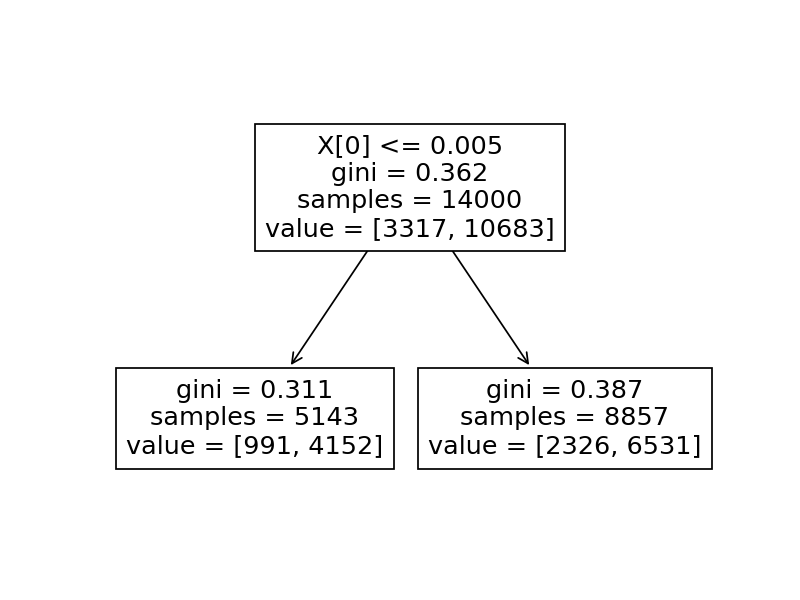

[Text(248.0, 277.2, 'X[0] <= 0.03\ngini = 0.362\nsamples = 14000\nvalue = [3317, 10683]'),
 Text(124.0, 92.39999999999998, 'gini = 0.347\nsamples = 4282\nvalue = [955, 3327]'),
 Text(372.0, 92.39999999999998, 'gini = 0.368\nsamples = 9718\nvalue = [2362, 7356]')]

In [10]:
plot_tree(dtc_WARP)

In [32]:
dot_data_WARP= StringIO()

export_graphviz(dtc_WARP, out_file=dot_data_WARP, filled=True, rounded=True, 
                special_characters=True, feature_names=X_train5_WARP.columns)
graph_WARP = pydotplus.graph_from_dot_data(dot_data_WARP.getvalue())
Image(graph_WARP.create_png(), width=2000, height=400)
graph_WARP.write_png('./img/decision_tree_WARP.png')

True

##### PLI_DARKAREAPERCENT

In [11]:
# Get Best hyperparamters
best_param_dtc_DAP = getBestHyperParam(x=X_train5_DAP, y=y_train5, classifier="DTC", scoring=None)
print(best_param_dtc_DAP)

Now tuning DTC. Go grab a beer or something.
Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    3.7s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.7s finished


In [12]:
dtc_DAP = best_param_dtc_DAP
dtc_DAP.fit(X_train5_DAP, y_train5)
dtc_DAP_pred = dtc_DAP.predict(X_test5_DAP)
dtc_DAP_score = accuracy_score(y_test5, dtc_DAP_pred)
print('Accuracy Rate: {0:.2f}%'.format(dtc_DAP_score * 100))

Accuracy Rate: 77.85%


In [13]:
plot_tree(dtc_DAP)

[Text(310.0, 346.5, 'X[0] <= 0.005\ngini = 0.362\nsamples = 14000\nvalue = [3317, 10683]'),
 Text(155.0, 115.5, 'gini = 0.311\nsamples = 5143\nvalue = [991, 4152]'),
 Text(465.0, 115.5, 'gini = 0.387\nsamples = 8857\nvalue = [2326, 6531]')]

In [38]:
dot_data_DAP= StringIO()

export_graphviz(dtc_DAP, out_file=dot_data_DAP, filled=True, rounded=True, 
                special_characters=True, feature_names=X_train5_DAP.columns)
graph_DAP = pydotplus.graph_from_dot_data(dot_data_DAP.getvalue())
Image(graph_DAP.create_png(), width=2000, height=400)
graph_DAP.write_png('./img/decision_tree_DAP.png')

True

#### 3d region

In [14]:
for col in ['P01_TTR_WARP','P01_PLI_DARKAREAPERCENT','NCELL']:
    print('{}: min: {}, max: {}'.format(col, df5[col].min(), df5[col].max()))

P01_TTR_WARP: min: 0.1936391, max: 129.5523987
P01_PLI_DARKAREAPERCENT: min: 0.0, max: 99.98908234
NCELL: min: 0.0, max: 0.228171


<IPython.core.display.Javascript object>


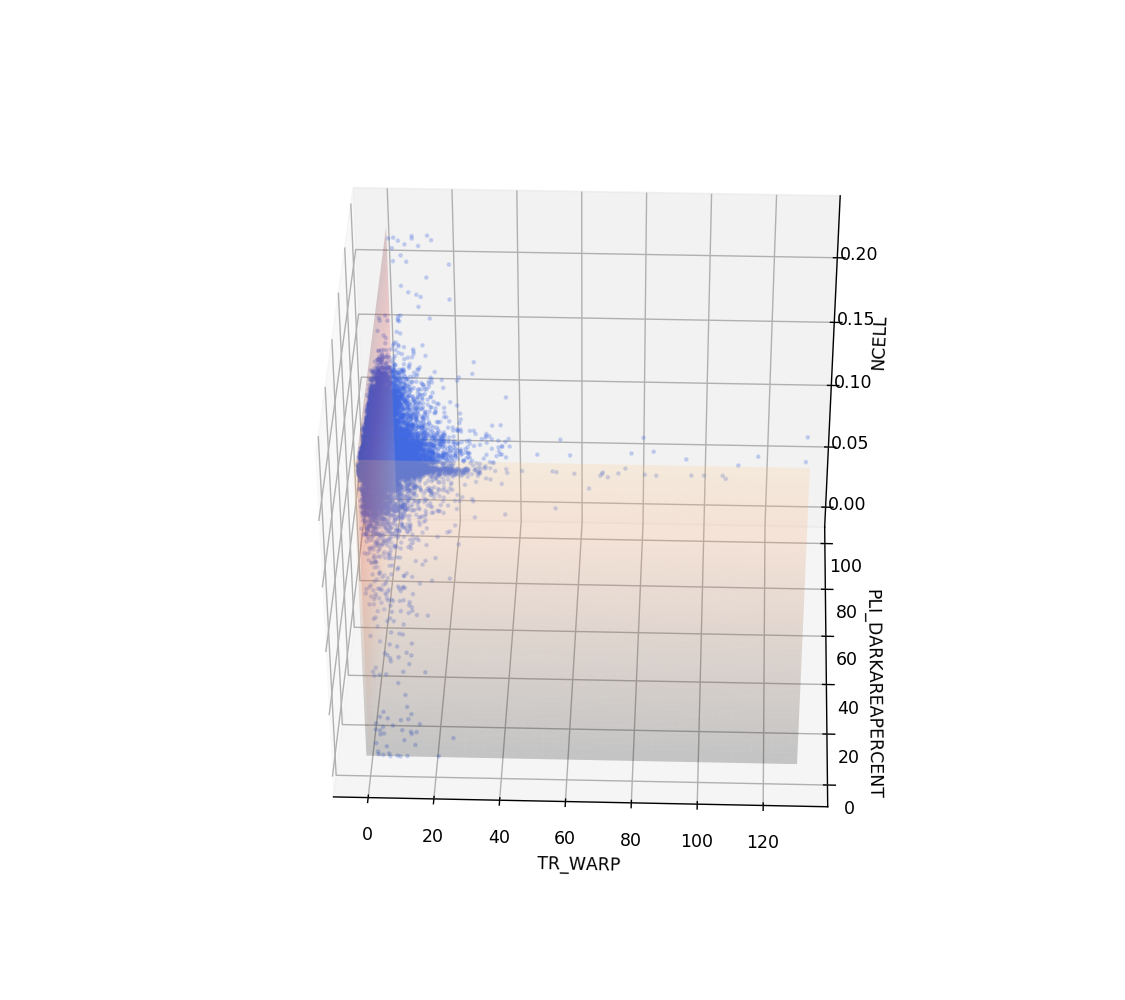

In [15]:
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(1,1,1, projection='3d')

xs = df5['P01_TTR_WARP']
ys = df5['P01_PLI_DARKAREAPERCENT']
zs = df5['NCELL']

ax.scatter(xs, ys, zs, marker='o', alpha=0.2, s=3, c='royalblue')

y1,z1 = np.meshgrid(range(int(np.trunc(ys.min())) -1, int(np.ceil(ys.max())) +1), 
                    np.linspace(zs.min(), round(zs.max(), 2), num=100))
x1 = 0.03
ax.plot_surface(x1, y1, z1, alpha=0.2, cmap=cm.Reds)


x2,z2 = np.meshgrid(range(int(np.trunc(xs.min())) -1, int(np.ceil(xs.max())) + 1), 
                    np.linspace(zs.min(), round(zs.max(), 2), num=100))
y2 = 0.005
ax.plot_surface(x2, y2, z2, alpha=0.2, cmap=cm.copper)


ax.set_xlabel("TR_WARP")
ax.set_ylabel("PLI_DARKAREAPERCENT")
ax.set_zlabel("NCELL")

plt.show()